In [1]:
%matplotlib inline
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import plotly.figure_factory as ff
import scipy
import os
import time
import math
from scipy.cluster.hierarchy import dendrogram

In [2]:
def plot_best_clusterings(G, D, k, pos, width = 16, height = 8):
    nb_plot = 2
    k1 = min(k,nb_plot)
    k2 = max(1,k // nb_plot)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '0.5','0.3','0.8', '0.6','0.2','0.7','0.1','0.9']
    plt.rcParams.update({'font.size': 24})
    plt.figure(figsize=(k1 * width, k2 * height))
    plt.subplots_adjust(left=.02, right=.98, bottom=.06, top=.85, wspace=.05, hspace=.05)
    for i in range(k):
        clustering = best_clustering(D, i)
        length = [len(c) for c in clustering]
        index = np.argsort(-np.array(length))

        plt.subplot(k2, k1, i + 1)
        plt.axis('off')
        plt.title("Rank: " + str(i + 1) + "\n(#clusters=" + str(len(clustering)) + ")")
        draw_nodes = nx.draw_networkx_nodes(G, pos, node_size=50, node_color='w')
        draw_nodes.set_edgecolor('k')
        nx.draw_networkx_edges(G, pos, alpha=.1)
        nodes = list(G.nodes())
        for l in range(min(len(clustering),len(colors))):
            nodelist = [nodes[i] for i in clustering[index[l]]]
            draw_nodes = nx.draw_networkx_nodes(G, pos, node_size=50, nodelist = nodelist,node_color=colors[l])
            draw_nodes.set_edgecolor('k')
    plt.show()

In [3]:
# Select the k-th best clustering
def best_clustering(D, k = 0):
    return select_clustering(D, rank_clustering(D)[k])

# Select the clustering after k merges

In [4]:
# Select the clustering after k merges
def select_clustering(D, k):
    n = np.shape(D)[0] + 1
    k = min(k,n - 1)
    cluster = {i:[i] for i in range(n)}
    for t in range(k):
        cluster[n + t] = cluster.pop(int(D[t][0])) + cluster.pop(int(D[t][1]))
    return sorted(cluster.values(), key = len, reverse = True)

In [5]:
# Rank clusterings at every level of the dendrogram
def rank_clustering(D):
    logdist = np.log(D[:,2])
    delta = logdist[1:] - logdist[:-1]
    return np.argsort(-delta[len(delta)//2:]) + 1 + len(delta)//2

In [6]:
def perf_algo(G, algo):
    if algo == "normalized":
        return normalized_dasgupta_cost(G,normalized)
    elif algo == "unnormalized":
        return normalized_dasgupta_cost(G,unnormalized)

In [7]:
##############################     
### Quality of a hierarchy ###
############################## 

# Normalized Dasgupta cost function
def normalized_dasgupta_cost(G,D):
    F = G.copy()
    n = F.number_of_nodes()

   # index nodes from 0 to n - 1
    if set(F.nodes()) != set(range(n)):
        F = nx.convert_node_labels_to_integers(F)
    
    # node weights
    w = {u: 0 for u in F.nodes()}
    wtot = 0
    for (u,v) in F.edges():
        if 'weight' not in F[u][v]:
            F[u][v]['weight'] = 1
        weight = F[u][v]['weight']
        w[u] += weight
        w[v] += weight
        wtot += weight
        if u != v:
            wtot += weight
    q = {u:1./n for u in F.nodes()}
    wtot = wtot / 2
    # aggregate graph
    H = F.copy()
    J = 0
    for t in range(n - 1):
        u = int(D[t][0])
        v = int(D[t][1])
        try:
            p = 1. * H[u][v]['weight'] / wtot
            J += p * (q[u] + q[v])
        except:
            pass
        H.add_node(n + t)
        neighbors_u = list(H.neighbors(u))
        neighbors_v = list(H.neighbors(v))
        for x in neighbors_u:
            H.add_edge(n + t,x,weight = H[u][x]['weight'])
        neighbors = list(H.neighbors(v))
        for x in neighbors_v:
            if H.has_edge(n + t,x):
                H[n + t][x]['weight'] += H[v][x]['weight']
            else:
                H.add_edge(n + t,x,weight = H[v][x]['weight'])
        H.remove_node(u)
        H.remove_node(v)
        q[n + t] = q.pop(u) + q.pop(v)
    return J

In [8]:
def run_time_algo(G, algo):
    t0 = time.time()
    D = spectral(G)
    t1 = time.time()
    return t1 - t0

In [9]:
# Read data (graph edges)
data_path = os.path.join('example1.dat')
with open(data_path) as f:
    edges = [tuple([int(x) for x in line.strip().split(',')]) for line in f]

In [10]:
# Extract nodes
nodes = np.unique(np.asarray(edges))
num_nodes = nodes.shape[0]

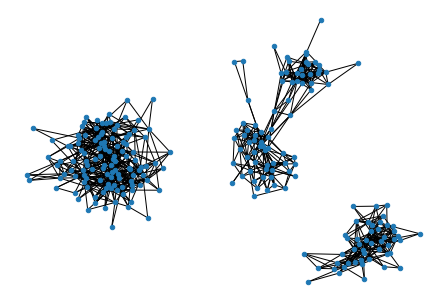

In [11]:
# Visualize graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G, node_size=20, pos=nx.spring_layout(G, k=0.05, iterations=20))
plt.show()

In [12]:
# Construct affinity matrix A
A = np.zeros([num_nodes, num_nodes])
for tup in edges:
    A[tup[0]-1, tup[1]-1] = 1

In [13]:
# Construct diagonal matrix D
D = np.diag(np.sum(A, axis=1))

In [14]:
# Construct the matrix L (called normalized laplacian)
D_ = np.linalg.inv(np.sqrt(D))
L = np.dot(np.dot(D_, A), D_)

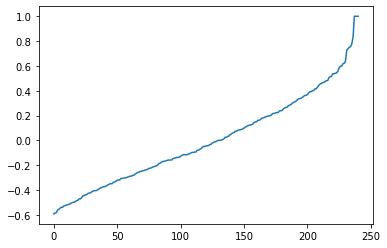

In [15]:
# Extract the eignevalues (ascending order) and normalized (unit “length”) eigenvectors of L 
w, v = scipy.linalg.eigh(L)
plt.plot(w)
plt.show()

In [16]:
# Find optimal k (where the eigenvalues start dropping)
k = np.argmin(np.ediff1d(np.flipud(w))) + 1
print('As expected, k = %d.' % k)

As expected, k = 4.


In [17]:
# Extract k largest eigenvectors
X = v[:, num_nodes - k:]

In [18]:
# Construct matrix Y by renormalizing X
Y = np.divide(X, np.reshape(np.linalg.norm(X, axis=1), (X.shape[0], 1)))

In [19]:
normalized = sch.linkage(Y,method =  'single')

C:\Users\amin\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\amin\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


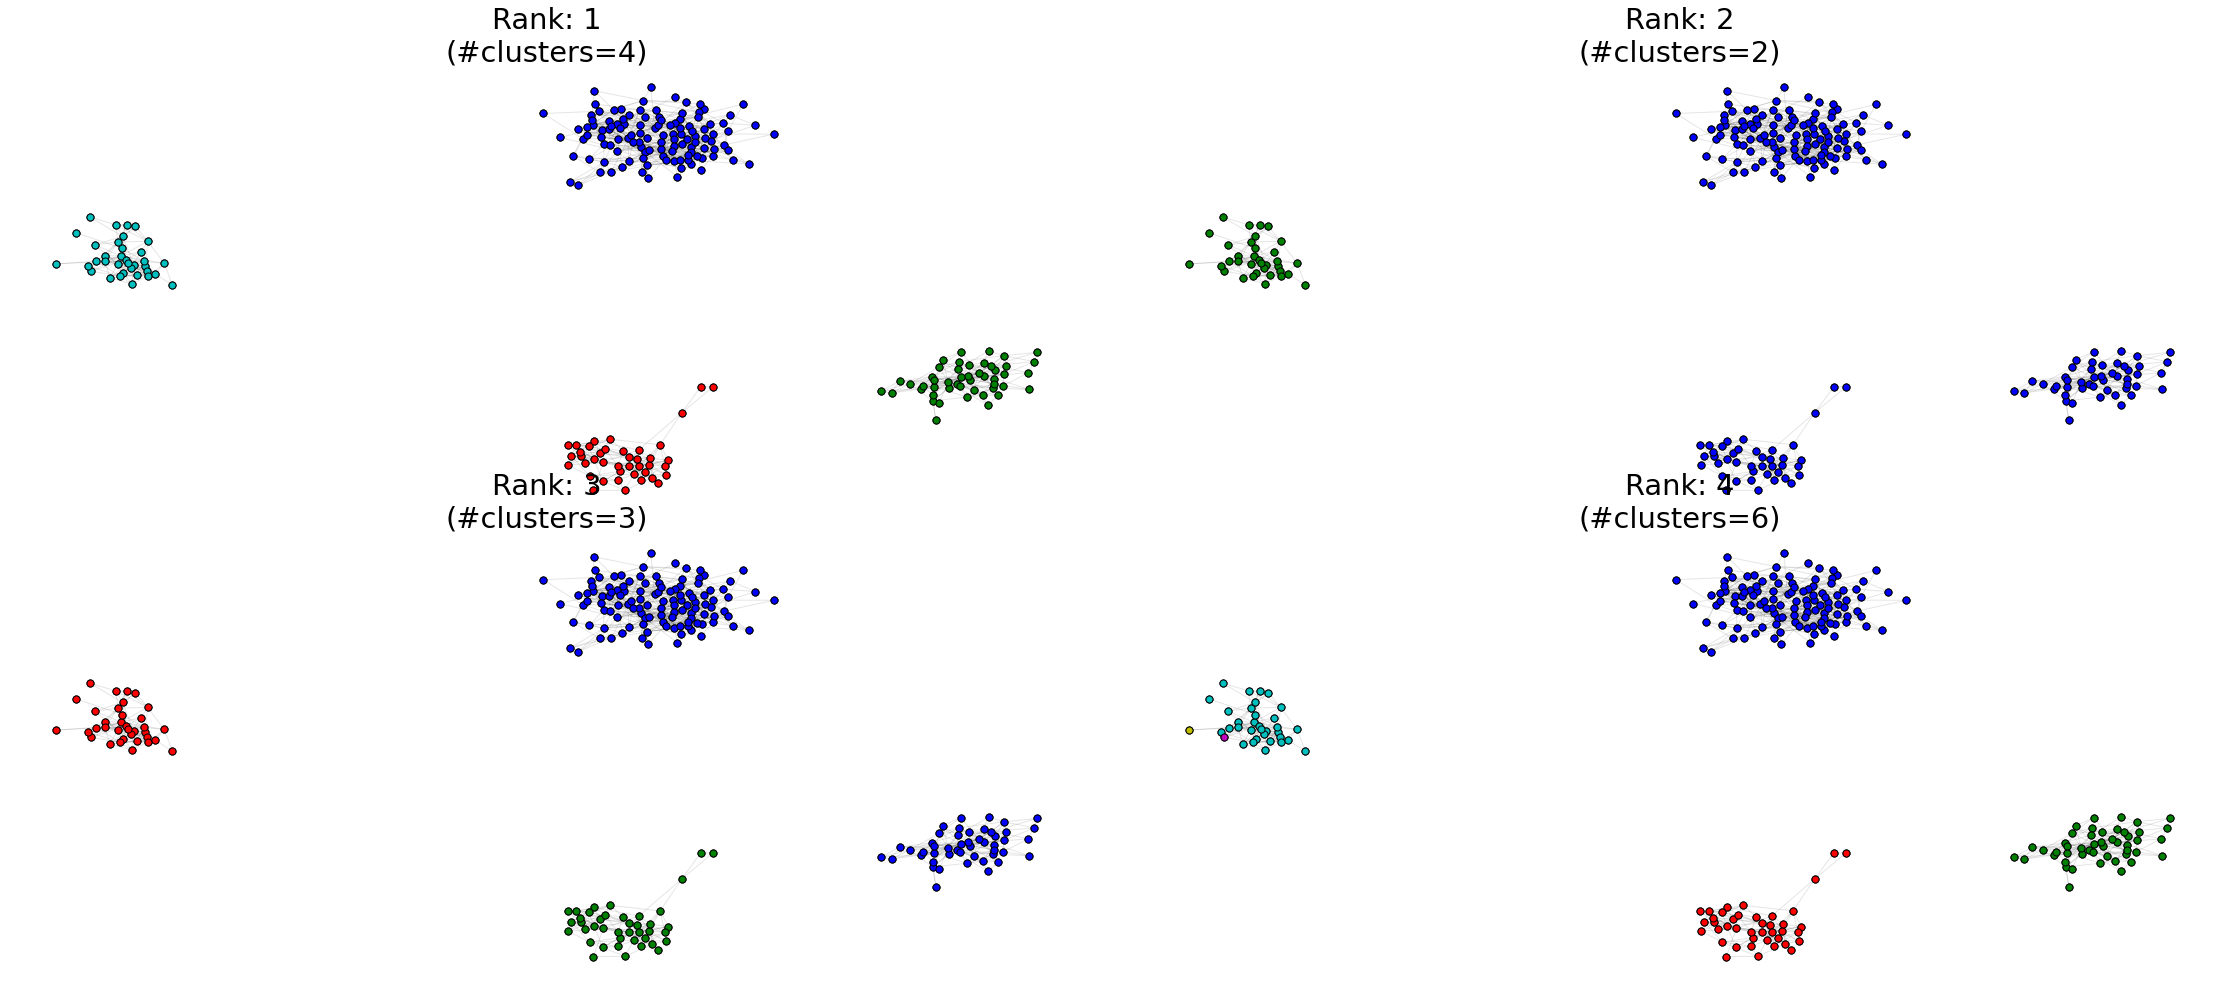

In [20]:
pos = nx.spring_layout(G)
plot_best_clusterings(G, normalized, 4, pos)

In [21]:
fig = ff.create_dendrogram(normalized)
fig.update_layout(width=800, height=500)
fig.show()

In [22]:
fig = ff.create_dendrogram(normalized, orientation='left')
fig.update_layout(width=800, height=800)
fig.show()

In [23]:
# Construct affinity matrix A
A = np.zeros([num_nodes, num_nodes])
for tup in edges:
    A[tup[0]-1, tup[1]-1] = 1

In [24]:
# Construct diagonal matrix D
D = np.diag(np.sum(A, axis=1))

In [25]:
# Construct Laplacian matrix L
L = D - A

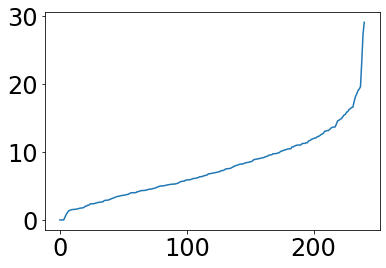

In [26]:
# Get eigenvalues in ascending order
w, v = scipy.linalg.eigh(L) 
plt.plot(w)
plt.show()

In [27]:
# Find optimal k (where the eigenvalues start dropping)
k = np.argmin(np.ediff1d(np.flipud(w))) + 1
print('not expected, k = %d.' % k)

not expected, k = 2.


In [28]:
# Extract k largest eigenvectors
X = v[:, num_nodes - k:]

In [29]:
unnormalized = sch.linkage(X,method =  'single')

C:\Users\amin\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

C:\Users\amin\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in subtract



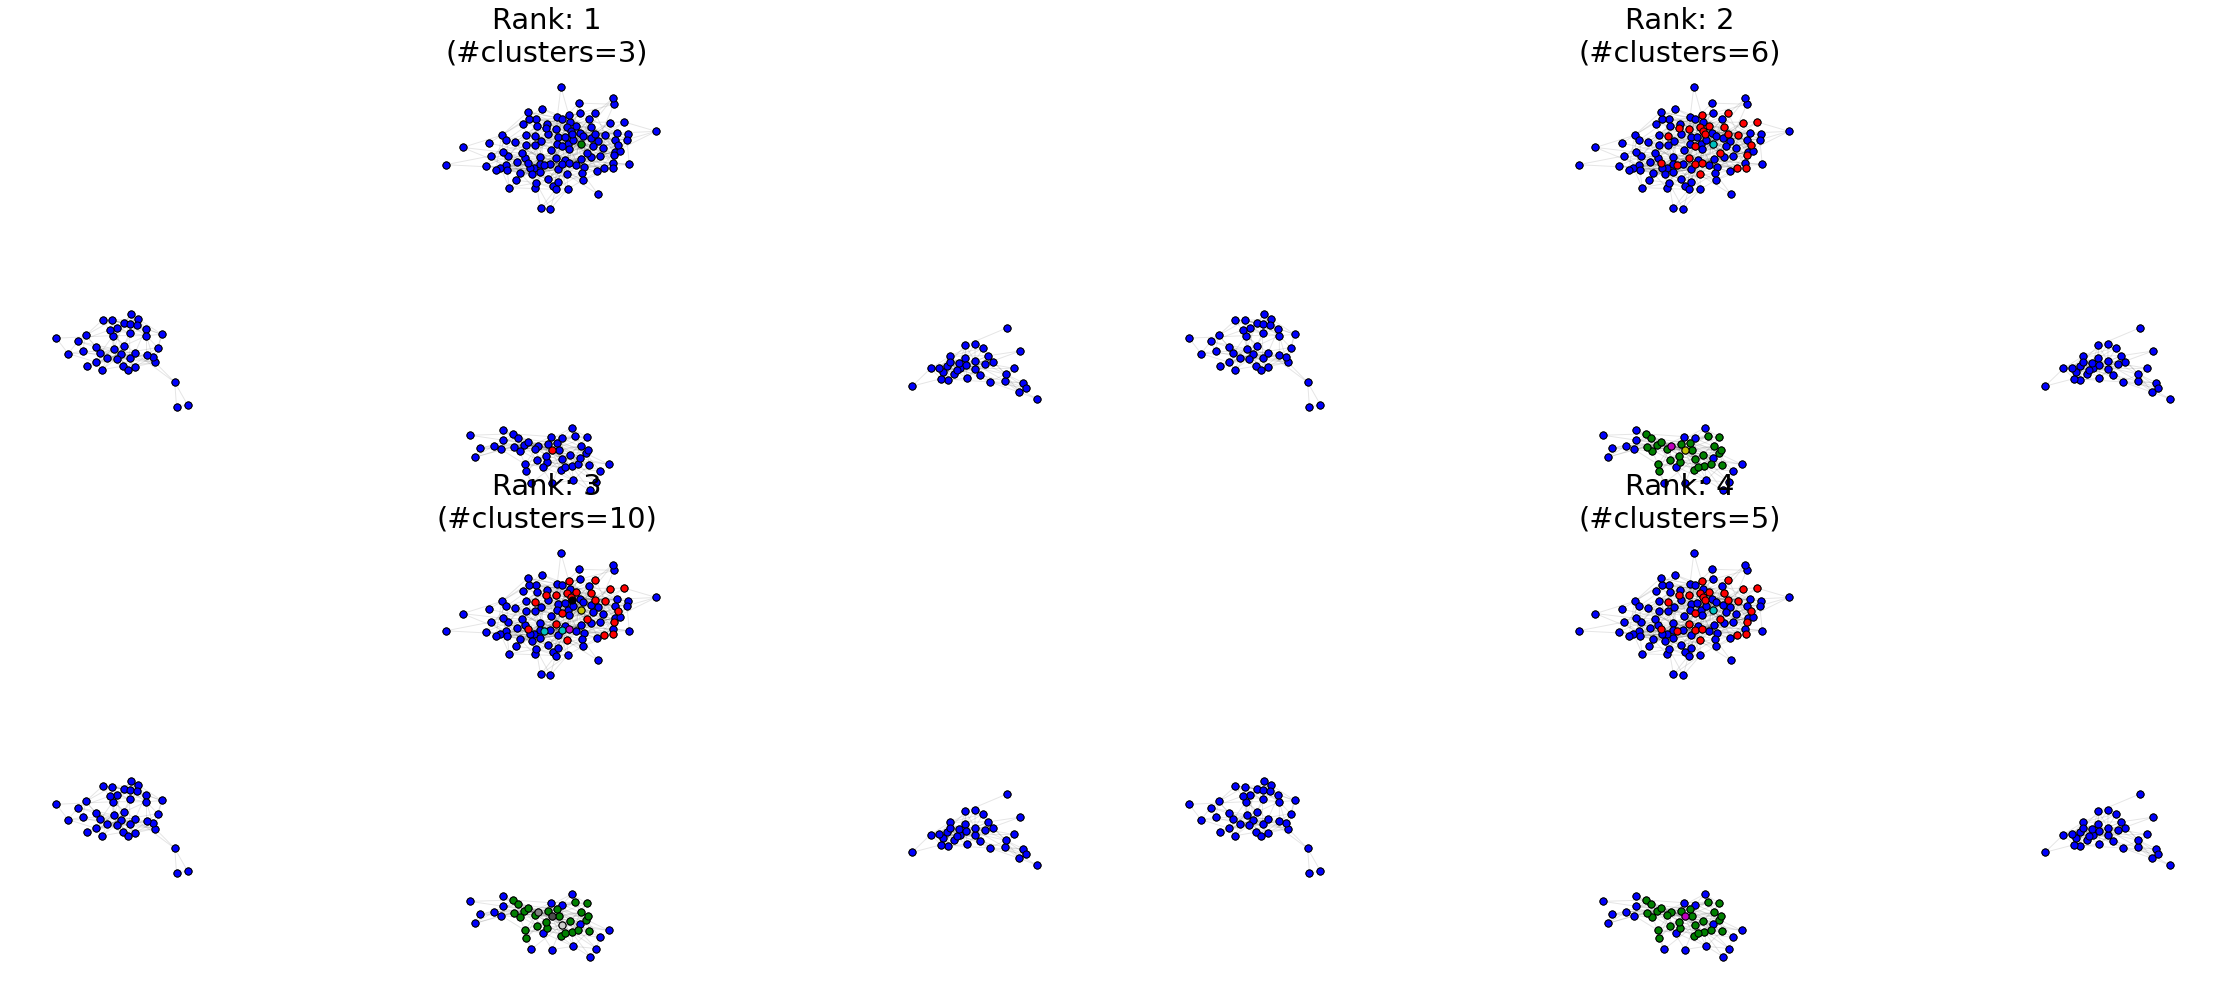

In [30]:
pos = nx.spring_layout(G)
plot_best_clusterings(G, unnormalized, 4, pos)

In [31]:
fig = ff.create_dendrogram(unnormalized)
fig.update_layout(width=800, height=500)
fig.show()

In [32]:
fig = ff.create_dendrogram(unnormalized, orientation='left')
fig.update_layout(width=800, height=800)
fig.show()

In [33]:
#unnormalized performance
perf_algo(G,"normalized")

0.19286289071807172

In [34]:
perf_algo(G,"unnormalized")

0.4846005493542168

In [35]:
# Get Fiedler Vector: The eigenvector corresponding to second smallest eigenvalue of L
fv = X[:, 1]

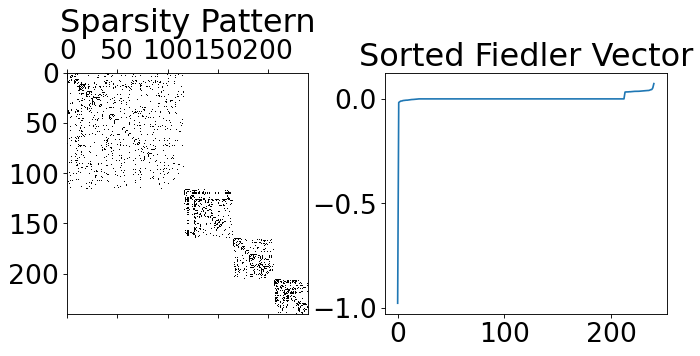

In [36]:
# Plot the sparsity pattern and sorted fiedler vector
fig=plt.figure(figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.spy(A) 
plt.title('Sparsity Pattern')
plt.subplot(1,2,2)
plt.plot(np.sort(fv))
plt.title('Sorted Fiedler Vector')
plt.show()

## Dataset 2

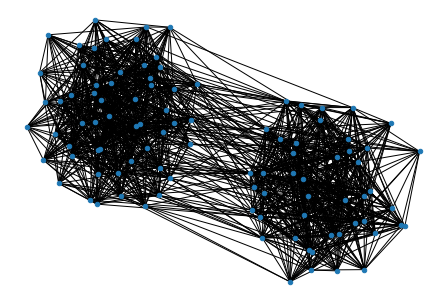

In [37]:
# Read data (graph edges)
data_path = os.path.join('example2.dat')
with open(data_path) as f:
    edges2 = [tuple([int(x) for x in line.strip().split(',')]) for line in f]
edges2 = [tuple([edge[0], edge[1]]) for edge in edges2]

# Extract nodes
nodes2 = np.unique(np.asarray(edges2))
num_nodes2 = nodes2.shape[0]

# Visualize graph
G2 = nx.Graph()
G2.add_nodes_from(nodes2)
G2.add_edges_from(edges2)
nx.draw(G2, node_size=20, pos=nx.spring_layout(G2, k=0.05, iterations=20))
plt.show()

In [38]:
# Construct affinity matrix A
A = np.zeros([num_nodes2, num_nodes2])
for tup in edges2:
    A[tup[0]-1, tup[1]-1] = 1

In [39]:
# Construct diagonal matrix D
D = np.diag(np.sum(A, axis=1))

In [40]:
# Construct the matrix L (called normalized laplacian)
D_ = np.linalg.inv(np.sqrt(D))
L = np.dot(np.dot(D_, A), D_)

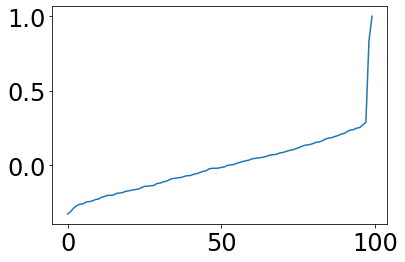

In [41]:
# Extract the eignevalues (ascending order) and normalized (unit “length”) eigenvectors of L 
w, v = scipy.linalg.eigh(L)
plt.plot(w)
plt.show()

In [42]:
# Find optimal k (where the eigenvalues start dropping)
k = np.argmin(np.ediff1d(np.flipud(w))) + 1
print('As expected, k = %d.' % k)

As expected, k = 2.


In [43]:
# Extract k largest eigenvectors
X = v[:, num_nodes2 - k:]

In [44]:
# Construct matrix Y by renormalizing X
Y = np.divide(X, np.reshape(np.linalg.norm(X, axis=1), (X.shape[0], 1)))

In [45]:
normalized = sch.linkage(Y,method =  'single')

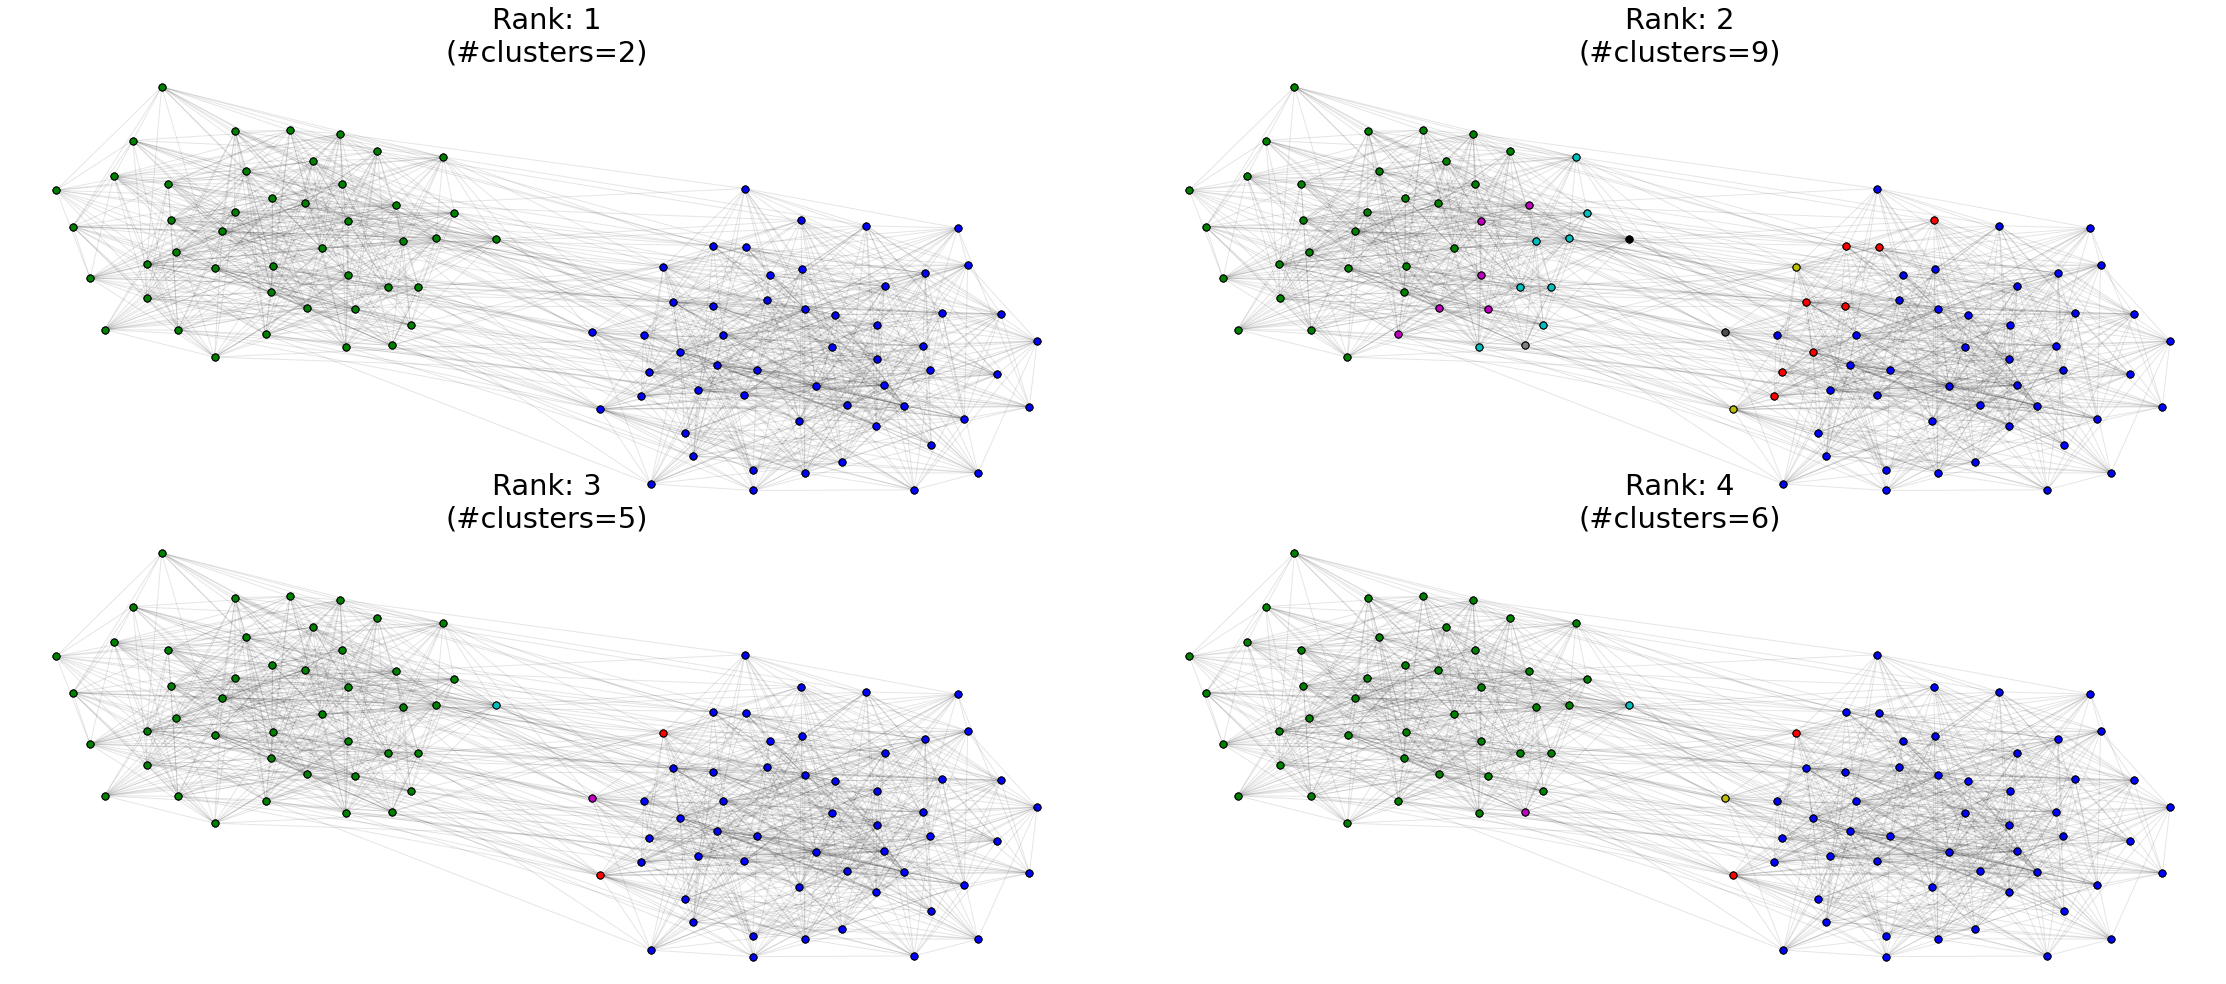

In [46]:
pos = nx.spring_layout(G2)
plot_best_clusterings(G2, normalized, 4, pos)

In [47]:
fig = ff.create_dendrogram(normalized)
fig.update_layout(width=800, height=500)
fig.show()

In [48]:
fig = ff.create_dendrogram(normalized, orientation='left')
fig.update_layout(width=800, height=800)
fig.show()

In [49]:
# Construct affinity matrix A
A = np.zeros([num_nodes2, num_nodes2])
for tup in edges2:
    A[tup[0]-1, tup[1]-1] = 1

In [50]:
# Construct diagonal matrix D
D = np.diag(np.sum(A, axis=1))

In [51]:
# Construct Laplacian matrix L
L = D - A

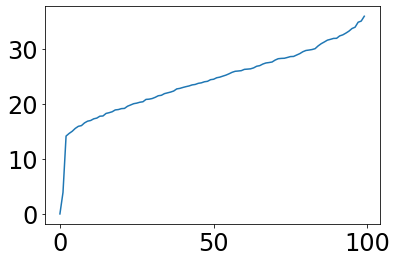

In [52]:
# Get eigenvalues in ascending order
w, v = scipy.linalg.eigh(L) 
plt.plot(w)
plt.show()

In [53]:
# Get Fiedler Vector: The eigenvector corresponding to second smallest eigenvalue of L
fv = X[:, 1]

In [54]:
# Find optimal k (where the eigenvalues start dropping)
k = np.argmin(np.ediff1d(np.flipud(w))) + 1
print('not expected, k = %d.' % k)

not expected, k = 98.


In [55]:
# Extract k largest eigenvectors
X = v[:, num_nodes - k:]

In [56]:
unnormalized = sch.linkage(X,method =  'single')

C:\Users\amin\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

C:\Users\amin\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in subtract



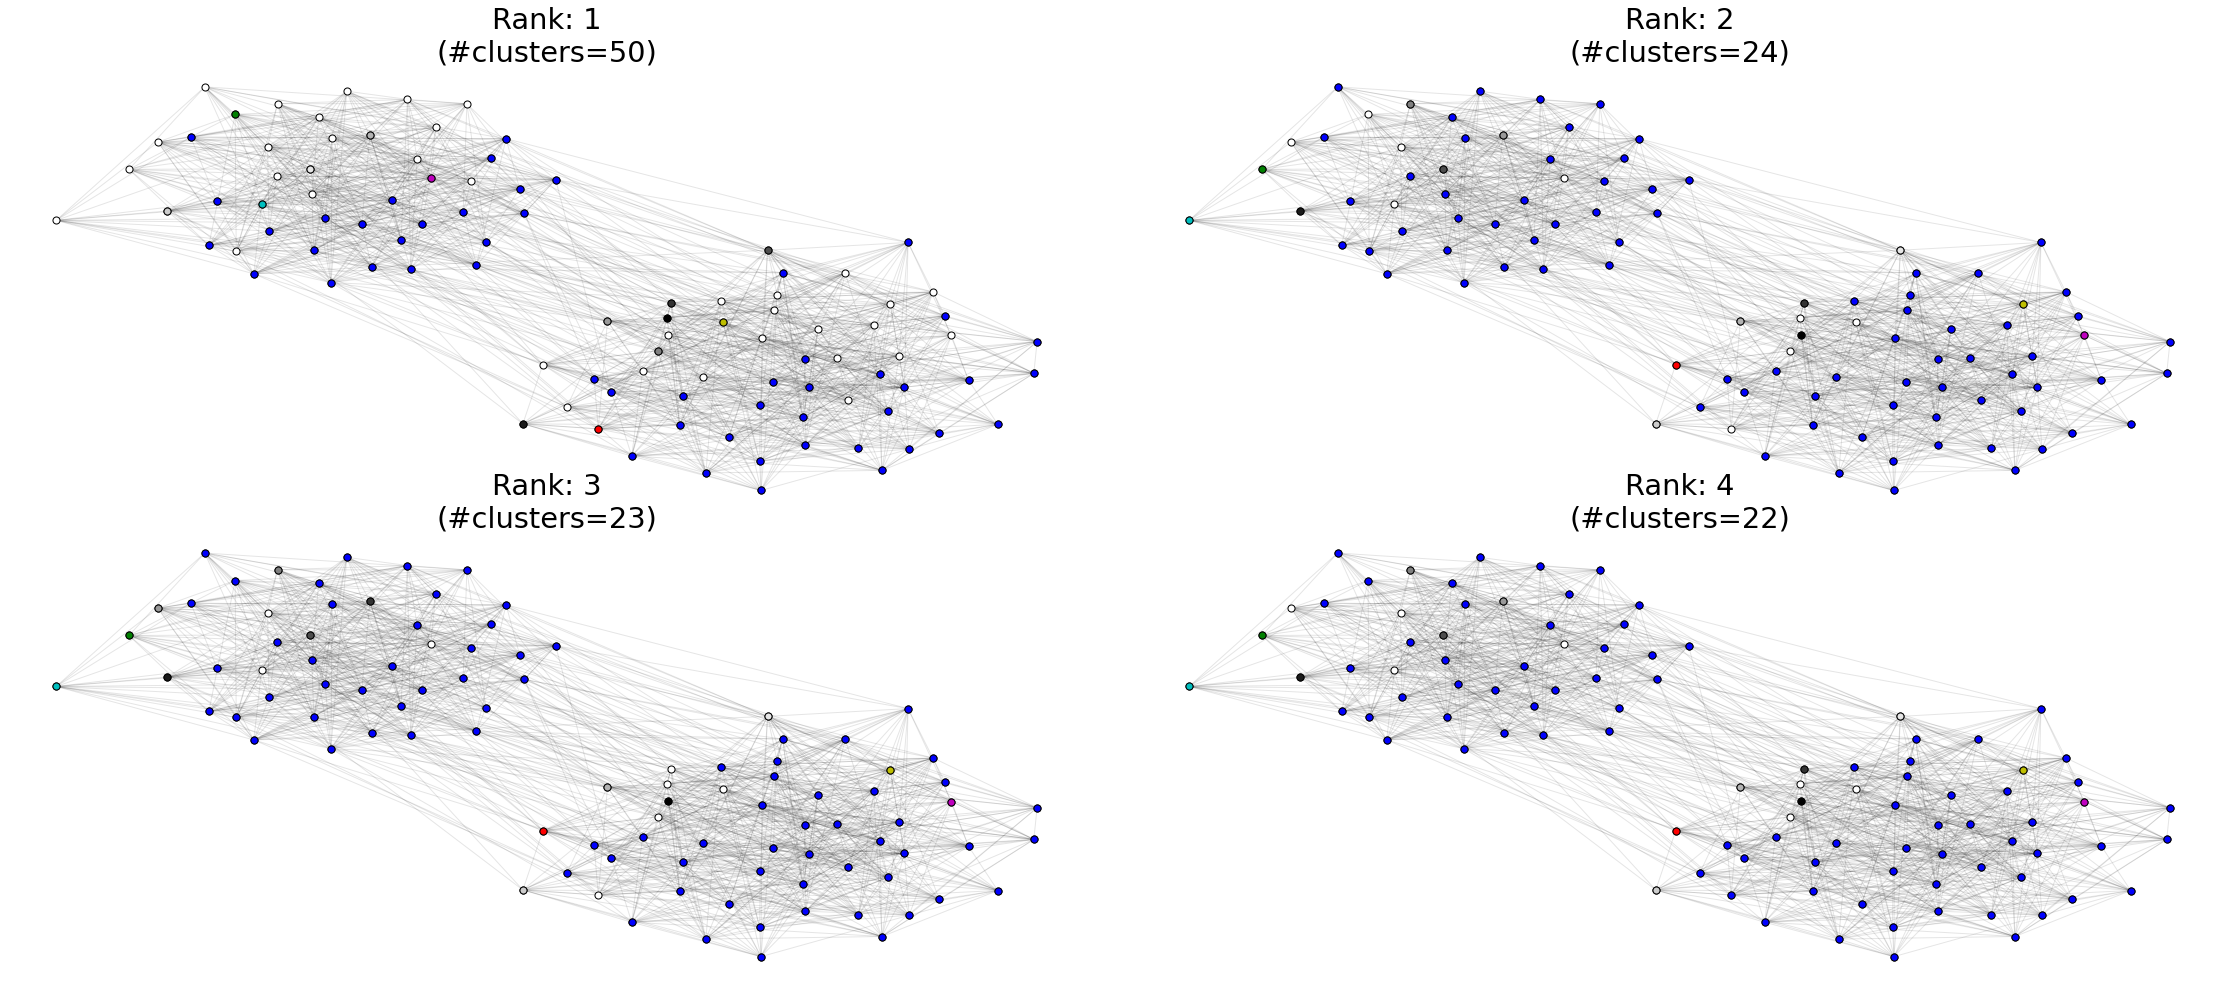

In [57]:
pos = nx.spring_layout(G2)
plot_best_clusterings(G2, unnormalized, 4, pos)

In [58]:
fig = ff.create_dendrogram(unnormalized)
fig.update_layout(width=800, height=500)
fig.show()

In [59]:
fig = ff.create_dendrogram(unnormalized, orientation='left')
fig.update_layout(width=800, height=800)
fig.show()

In [60]:
#unnormalized performance
perf_algo(G2,"normalized")

0.4017452440033085

In [61]:
perf_algo(G2,"unnormalized")

0.6698263027295288

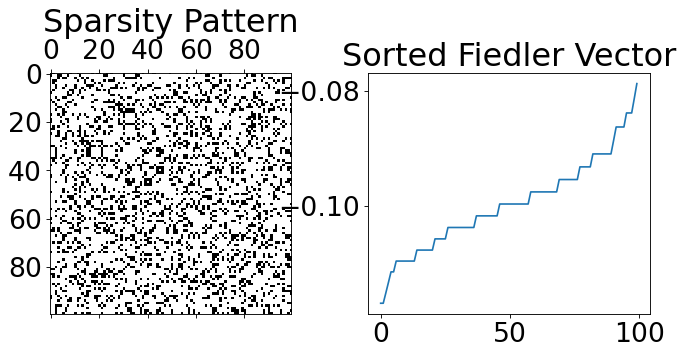

In [62]:
# Plot the sparsity pattern and sorted fiedler vector
fig=plt.figure(figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.spy(A) 
plt.title('Sparsity Pattern')
plt.subplot(1,2,2)
plt.plot(np.sort(fv))
plt.title('Sorted Fiedler Vector')
plt.show()